<a href="https://colab.research.google.com/github/RoGiraldez/visual_search_pps/blob/main/entrenamiento_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento MobileNet

## Librerias a utilizar

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
#from SpatialPyramidPooling import SpatialPyramidPooling
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
import pandas as pd
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

El conjunto de imágenes a utilizar está subida a mi cuenta personal de drive, entonces utilizaré a la misma como almacenamiento y para ello debo ejecutar la siguiente celda

In [ ]:
#montar el almacenamiento de drive en donde guardamos la BD
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se crea un data generator con algunas transformaciones de data augmentation tanto para el set de entrenamiento como para el de validación

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32
base_dir = "/content/drive/My Drive/BaseDeDatos/WHU-RS19" #ruta de mi drive en 
#donde cargue las imágenes

train_set = train_datagen.flow_from_directory(base_dir + '/train',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(base_dir + '/validation',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              class_mode='categorical')

Found 490 images belonging to 19 classes.
Found 460 images belonging to 19 classes.


## Se define el modelo

Se aplica transfer learning 

In [ ]:
base_model = keras.applications.MobileNet(
    weights="imagenet",  # se cargan los pesos del modelo entrenado con ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # no se incluye la capa de clasificación de 1000 clases correspondiente a ImageNet
)  

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
# Se congela el modelo base
base_model.trainable = False

# Se crea el modelo nuevo
inputs = keras.Input(shape=(224, 224, 3))

# El modelo base contiene capas de Batch Normalization. El objetivo es que estas permanezcan
# en modo inferencia (predicción, no entrenamiento) al descongelar el modelo base para
# utilizar la técnica de fine-tunninig. Para ello debemos asegurarnos que el modelo base corra
# en modo inferencia aquí.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(19)(x)

mobilenet_model = keras.Model(inputs, outputs, name='pretrained_mobilenet')
mobilenet_model.summary()

Model: "pretrained_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                19475     
Total params: 3,248,339
Trainable params: 19,475
Non-trainable params: 3,228,864
_________________________________________________________________


**Compilación y entrenamiento del modelo**

In [ ]:
mobilenet_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=[keras.metrics.CategoricalAccuracy()]
)

epochs = 20
batch_size = 32
print(len(train_set))
print(len(valid_set)//batch_size)
mobilenet_history = mobilenet_model.fit(train_set,                             
                                        validation_data=valid_set,
                                        epochs=epochs,                                   
)

16
0
Epoch 1/20
16/16 [==============================] - 13s 753ms/step - loss: 4.1075 - categorical_accuracy: 0.1194 - val_loss: 3.6535 - val_categorical_accuracy: 0.1630
Epoch 2/20
16/16 [==============================] - 11s 712ms/step - loss: 1.5053 - categorical_accuracy: 0.5336 - val_loss: 1.9085 - val_categorical_accuracy: 0.4152
Epoch 3/20
16/16 [==============================] - 11s 714ms/step - loss: 0.7348 - categorical_accuracy: 0.7891 - val_loss: 1.5215 - val_categorical_accuracy: 0.5065
Epoch 4/20
16/16 [==============================] - 11s 714ms/step - loss: 0.4051 - categorical_accuracy: 0.8763 - val_loss: 1.0089 - val_categorical_accuracy: 0.6674
Epoch 5/20
16/16 [==============================] - 11s 722ms/step - loss: 0.3234 - categorical_accuracy: 0.9038 - val_loss: 0.8906 - val_categorical_accuracy: 0.7043
Epoch 6/20
16/16 [==============================] - 11s 714ms/step - loss: 0.2526 - categorical_accuracy: 0.9375 - val_loss: 0.9272 - val_categorical_accuracy: 


Evaluación del modelo en datos de validación

In [ ]:
results = mobilenet_model.evaluate(valid_set)
print('val loss:', results[0])
print('val acc:', results[1])

15/15 [==============================] - 3s 226ms/step - loss: 0.5592 - categorical_accuracy: 0.8478
val loss: 0.559186577796936
val acc: 0.8478260636329651


Se grafica el progreso del entrenamiento


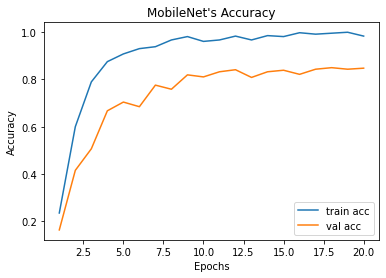

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_acc = mobilenet_history.history['categorical_accuracy']
val_acc = mobilenet_history.history['val_categorical_accuracy']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train acc')
plt.plot(epochs_list, val_acc, label='val acc')
plt.title("MobileNet's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

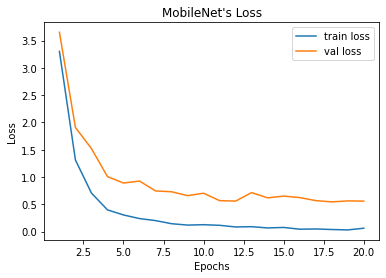

In [ ]:
train_loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

plt.plot(epochs_list, train_loss, label='train loss')
plt.plot(epochs_list, val_loss, label='val loss')
plt.title("MobileNet's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')


Save the model

In [ ]:
mobilenet_model.save('mobilenet')

INFO:tensorflow:Assets written to: mobilenet/assets


Unfreeze the base model and apply fine-tuning of the weights

In [ ]:
# Se descongela el modelo base. Acá las capas de Batch Normalization
# no actualizaran las estadísticas propias de ellas. Esto es porque
# al efectuar la llamada al modelo le pasamos 'training=False', lo cual
# previene que se deshaga todo el entrenamiento que hemos hecho hasta ahora
base_model.trainable = True
mobilenet_model.summary()

Model: "pretrained_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                19475     
Total params: 3,248,339
Trainable params: 3,226,451
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
mobilenet_model.compile(optimizer=keras.optimizers.Adam(1e-5),  # tasa de aprendizaje pequeña
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=[keras.metrics.CategoricalAccuracy()]
)

epochs = 10

mobilenet_ft_history = mobilenet_model.fit(train_set,
                                           validation_data=valid_set,
                                           epochs=epochs,
                                       
)

Epoch 1/10
16/16 [==============================] - 15s 824ms/step - loss: 0.0643 - categorical_accuracy: 0.9833 - val_loss: 0.7050 - val_categorical_accuracy: 0.8239
Epoch 2/10
16/16 [==============================] - 12s 777ms/step - loss: 0.0344 - categorical_accuracy: 0.9977 - val_loss: 0.6415 - val_categorical_accuracy: 0.8304
Epoch 3/10
16/16 [==============================] - 13s 786ms/step - loss: 0.0425 - categorical_accuracy: 0.9939 - val_loss: 0.5545 - val_categorical_accuracy: 0.8522
Epoch 4/10
16/16 [==============================] - 12s 777ms/step - loss: 0.0359 - categorical_accuracy: 0.9938 - val_loss: 0.5255 - val_categorical_accuracy: 0.8652
Epoch 5/10
16/16 [==============================] - 12s 768ms/step - loss: 0.0324 - categorical_accuracy: 0.9893 - val_loss: 0.7481 - val_categorical_accuracy: 0.8109
Epoch 6/10
16/16 [==============================] - 12s 764ms/step - loss: 0.0279 - categorical_accuracy: 0.9917 - val_loss: 0.6447 - val_categorical_accuracy: 0.845


Evaluate the fine-tuned model

In [ ]:
results = mobilenet_model.evaluate(valid_set)
print('val loss:', results[0])
print('val acc:', results[1])

15/15 [==============================] - 3s 227ms/step - loss: 0.5924 - categorical_accuracy: 0.8674
val loss: 0.5924205183982849
val acc: 0.8673912882804871



Plot the training progress of the fine-tuned model

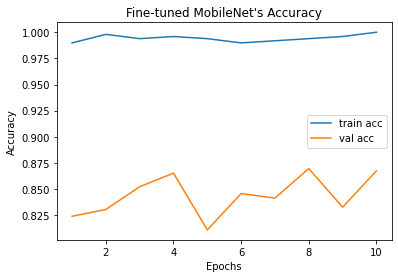

In [ ]:
train_acc = mobilenet_ft_history.history['categorical_accuracy']
val_acc = mobilenet_ft_history.history['val_categorical_accuracy']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train acc')
plt.plot(epochs_list, val_acc, label='val acc')
plt.title("Fine-tuned MobileNet's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

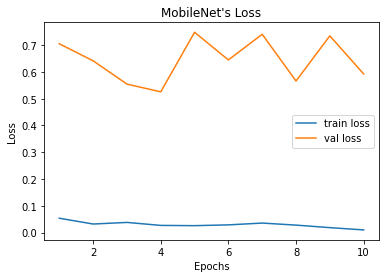

In [ ]:
train_loss = mobilenet_ft_history.history['loss']
val_loss = mobilenet_ft_history.history['val_loss']

plt.plot(epochs_list, train_loss, label='train loss')
plt.plot(epochs_list, val_loss, label='val loss')
plt.title("MobileNet's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

Save the fine-tuned model

In [ ]:
mobilenet_model.save('mobilenet-fine-tuned.h5')



In [ ]:
mobilenet_model.save_weights('PESOS.h5')


Ejemplo de como corroborar recursos brindados por Colaboratory

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=c6c368745737e59f1863a1dc387ef19bea948a26606ae0efe66aaa211074fc6e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 118.4 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB
